In [6]:
import pandas as pd
from matminer.featurizers.conversions import StrToComposition

from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, ShuffleSplit, KFold


import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('Li_materials.csv')
import ast
chemical_formulas = [''.join([key + str(int(val)) for key, val in ast.literal_eval(formula).items()]) for formula in data["formula"]]
data.insert(loc=2, column='chemical_formula', value=chemical_formulas)
data = StrToComposition().featurize_dataframe(data, "chemical_formula", ignore_errors=True)

StrToComposition: 100%|██████████| 19480/19480 [00:08<00:00, 2341.88it/s] 


In [3]:
feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                          cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])

feature_labels = feature_calculators.feature_labels()

data = feature_calculators.featurize_dataframe(data, col_id='composition')

original_count = len(data)
data = data[~ data[feature_labels].isnull().any(axis=1)]
print('Removed %d/%d entries'%(original_count - len(data), original_count))

MultipleFeaturizer: 100%|██████████| 19480/19480 [00:55<00:00, 350.40it/s]


Removed 0/19480 entries


In [4]:
data.head(5)

,Unnamed: 0,material_id,chemical_formula,formula,spacegroup.symbol,cif,formation_energy_per_atom,composition,0-norm,2-norm,...,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char
0,0,mp-10173,Li1,{'Li': 1.0},P6_3/mmc,# generated using pymatgen\ndata_Li\n_symmetry...,0.002524,(Li),1,1.0,...,229.0,0.0,229.0,1.0,0.0,0.0,0.0,True,0.0,0.0
1,1,mp-1018134,Li1,{'Li': 1.0},R-3m,# generated using pymatgen\ndata_Li\n_symmetry...,0.000000,(Li),1,1.0,...,229.0,0.0,229.0,1.0,0.0,0.0,0.0,True,0.0,0.0
2,2,mp-567337,Li1,{'Li': 1.0},I-43d,# generated using pymatgen\ndata_Li\n_symmetry...,0.010352,(Li),1,1.0,...,229.0,0.0,229.0,1.0,0.0,0.0,0.0,True,0.0,0.0
3,3,mp-1063005,Li1,{'Li': 1.0},P6/mmm,# generated using pymatgen\ndata_Li\n_symmetry...,0.018578,(Li),1,1.0,...,229.0,0.0,229.0,1.0,0.0,0.0,0.0,True,0.0,0.0
4,4,mp-976411,Li1,{'Li': 1.0},P6_3/mmc,# generated using pymatgen\ndata_Li\n_symmetry...,0.002798,(Li),1,1.0,...,229.0,0.0,229.0,1.0,0.0,0.0,0.0,True,0.0,0.0


### RF model - CV - hyperparameter search

In [7]:
model = GridSearchCV(RandomForestRegressor(n_estimators=20, n_jobs=-1),
                     param_grid=dict(max_features=range(8,15)),
                     scoring='neg_mean_squared_error',cv=ShuffleSplit(n_splits=1, test_size=0.1))

In [8]:
model.fit(data[feature_labels], data['formation_energy_per_atom'])

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.1, train_size=None),
             estimator=RandomForestRegressor(n_estimators=20, n_jobs=-1),
             param_grid={'max_features': range(8, 15)},
             scoring='neg_mean_squared_error')

Text(0, 0.5, 'RMSE (eV/atom)')

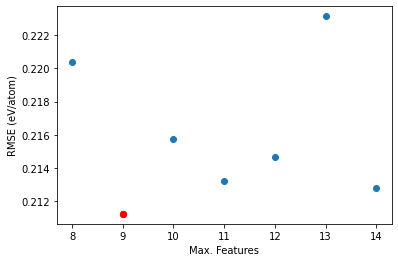

In [9]:
fig, ax = plt.subplots()

# Plot the score as a function of alpha
ax.scatter(model.cv_results_['param_max_features'].data,np.sqrt(-1 * model.cv_results_['mean_test_score']))
ax.scatter([model.best_params_['max_features']], np.sqrt([-1*model.best_score_]), marker='o', color='r', s=40)
ax.set_xlabel('Max. Features')
ax.set_ylabel('RMSE (eV/atom)')

RMSE of 0.212 -> MAE of 0.212 eV per atom.  0.03 eV is chemical accuracy